<a href="https://colab.research.google.com/github/ddovidovich/DataScienceLerning/blob/main/UNIT_13_DZ_Ultra_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Создайте веб-сервис с помощью FastAPI, загрузите на него обученную модель MNIST и протестируйте ее на собственноручно написанных цифрах.




In [1]:
# Ваше решение


## Создание веб-сервиса с помощью FastAPI

In [2]:
!pip install fastapi
!pip install uvicorn
!pip install python-multipart

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 5.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 3.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 2.0 MB/s eta 0:00:00


Создадим файл с тестовым API:

In [3]:
main_file = '''from fastapi import FastAPI

app = FastAPI()

@app.get("/test")
def read_root():
    return {"Hello": "World"}
'''

with open('main.py', 'w') as file:
    file.write(main_file)

Запустим http-сервер **uvicorn** с указанием приложения, которое будет запускаться (**app** из файла **main.py**):

In [4]:
!nohup uvicorn main:app --reload &
# nohup и & - прописываются для запуска процесса в фоне (чтобы не блокировать Colab)
# параметр --reload позволяет автоматически перезапускать uvicorn при изменениях в файле main.py

nohup: appending output to 'nohup.out'


In [5]:
!cat nohup.out

In [7]:
import requests
r = requests.get('http://127.0.0.1:8000/test')
print(r.status_code)
print(r.text)

200
{"Hello":"World"}


Вебсервер работает и дает отклик на наши действия. Перейдем к следующему этапу.

## Создание и загрузка на сервер предобученной модели MNIST

In [8]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
# параметры модели
num_classes = 10
input_shape = (28, 28, 1)

# загрузка MNIST данных
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# приведение данных к размерности от 0 до 1
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "тренировочные данные")
print(x_test.shape[0], "тестовые данные")


# преобразования из вектора в бинарную матрицу
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 тренировочные данные
10000 тестовые данные


### Создадим модель

In [10]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [11]:
#натренируем модель на тестовых данных
batch_size = 128
epochs = 20

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/20
422/422 [==============================] - 51s 118ms/step - loss: 0.3769 - accuracy: 0.8851 - val_loss: 0.0834 - val_accuracy: 0.9783
Epoch 2/20
422/422 [==============================] - 47s 111ms/step - loss: 0.1149 - accuracy: 0.9644 - val_loss: 0.0566 - val_accuracy: 0.9852
Epoch 3/20
422/422 [==============================] - 48s 115ms/step - loss: 0.0850 - accuracy: 0.9740 - val_loss: 0.0481 - val_accuracy: 0.9868
Epoch 4/20
422/422 [==============================] - 47s 111ms/step - loss: 0.0720 - accuracy: 0.9782 - val_loss: 0.0423 - val_accuracy: 0.9865
Epoch 5/20
422/422 [==============================] - 46s 108ms/step - loss: 0.0637 - accuracy: 0.9802 - val_loss: 0.0408 - val_accuracy: 0.9885
Epoch 6/20
422/422 [==============================] - 46s 109ms/step - loss: 0.0570 - accuracy: 0.9824 - val_loss: 0.0363 - val_accuracy: 0.9905
Epoch 7/20
422/422 [==============================] - 45s 107ms/step - loss: 0.0527 - accuracy: 0.9835 - val_loss: 0.0367 - val_ac

In [12]:
# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt 

def plot_history(history):
    plt.figure(figsize=(14,7))
    plt.subplot (1, 2, 1)
    plt.plot(history.history['loss'], 
            label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(history.history['val_loss'], 
            label='Средняя абсолютная ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    
    plt.subplot (1, 2, 2)
    plt.plot(history.history['accuracy'], 
            label='Средняя точность на обучающем наборе')
    plt.plot(history.history['val_accuracy'], 
            label='Средняя точность на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя точность')
    plt.legend()
    plt.show()

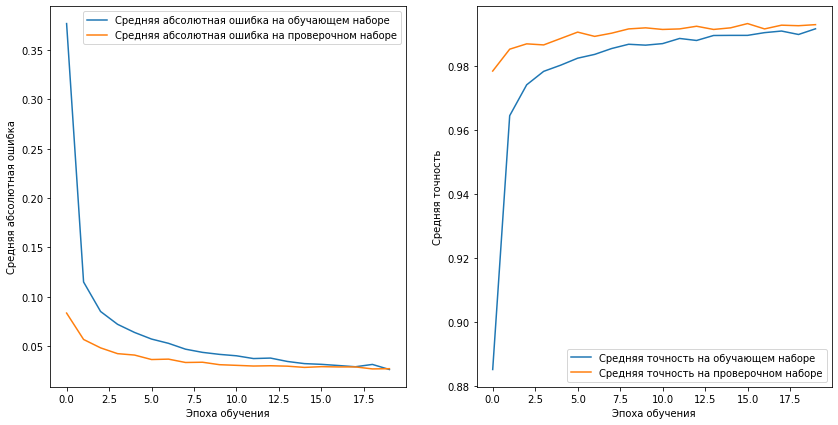

In [13]:
plot_history(history)

In [14]:
# проверка точности модели на тестовой выборке
score = model.evaluate(x_test, y_test, verbose=0)
print("Ошибка:", score[0])
print("Точность:", score[1])

Ошибка: 0.02399793453514576
Точность: 0.9926000237464905


Как мы видим, модель достаточно точна, можно ее сохранить и загрузить на сервер.

In [15]:
# Сохранение обученной модели полностью (веса и архитектура) после всех эпох

model.save('mnist_model.h5')

Создадим файл с кодом для инициализации модели, загрузки весов, предобработки изображения и инференса (режима предсказания) модели:

In [16]:
predict_file = '''

from tensorflow.keras.models import load_model
import numpy as np
from io import BytesIO
from PIL import Image 

INPUT_SHAPE = (28, 28, 1)

model = load_model('mnist_model.h5')  # Инициализация модели


def process(image_file):
    
    img = Image.open(BytesIO(image_file)) 
    img = img.convert('L')
    img = img.resize((28, 28))
    img_array = np.array(img)
    img_array = img_array.reshape(1, 28, 28, 1)
    img_array = img_array / 255.0
    prediction = model.predict(img_array)
    predicted_digit = np.argmax(prediction)

    return {'На картинке цифра': int(predicted_digit)}
'''

# Сохранение кода в файл
with open('predict.py', 'w') as file:
    file.write(predict_file)

Создадим новый эндпойнт, который будет принимать файл с изображением и возвращать результат:

In [17]:
main_file = '''from fastapi import FastAPI, File
from predict import process

app = FastAPI()


@app.post("/predict")
async def create_file(file: bytes = File(...)):
    return {"result": process(file)}
'''

with open('main.py', 'w') as file:
    file.write(main_file)

In [35]:
# Загрузка собственных рукописных цифр из облака

import gdown
gdown.download('https://fastupload.io/download/1jar3XjXQG2dD/hEk9igBQjZjo39e/nums.zip', None, quiet=True)

'nums.zip'

In [36]:
!unzip -q nums.zip

replace num_2.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


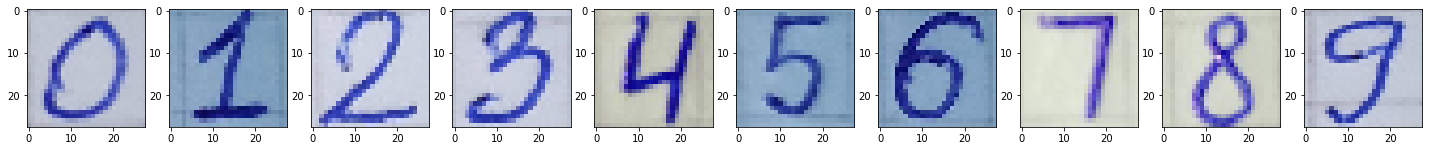

In [40]:
# Метод для загрузки изображений
from tensorflow.keras.preprocessing.image import load_img 

# Вывод для примера картинок по каждому классу

# Создание полотна из десяти графиков
import matplotlib.pyplot as plt  
fig, axs = plt.subplots(1, 10, figsize=(25, 5)) 

# Проход и отрисовка по всем картинкам
for i in range(10):
    img = load_img('num_' + str(i) + '.jpg', target_size=(28, 28)) 
    axs[i].imshow(img, cmap = 'gray')

# Вывод изображений
plt.show() 

In [44]:
# Загрузка тестовых изображений и :
for i in range(10):
    files = {'file': open('num_' + str(i) + '.jpg','rb')}
    r = requests.post('http://127.0.0.1:8000/predict', files=files)
    print(r.text, ' оригинал цифра:' + str(i))

{"result":{"На картинке цифра":8}}  оригинал цифра:0
{"result":{"На картинке цифра":0}}  оригинал цифра:1
{"result":{"На картинке цифра":8}}  оригинал цифра:2
{"result":{"На картинке цифра":8}}  оригинал цифра:3
{"result":{"На картинке цифра":4}}  оригинал цифра:4
{"result":{"На картинке цифра":8}}  оригинал цифра:5
{"result":{"На картинке цифра":8}}  оригинал цифра:6
{"result":{"На картинке цифра":1}}  оригинал цифра:7
{"result":{"На картинке цифра":8}}  оригинал цифра:8
{"result":{"На картинке цифра":8}}  оригинал цифра:9
